In [1]:
import pathlib as pl
from configparser import ConfigParser
from gc import collect

import joblib as jl
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

from src.metrics.consolidated_tstat import tstat_cluster_mass
from src.visualization.interactive import plot_raw_pair, plot_time_ser_quant
from src.root_path import config_path

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-05-25 172722.log


In [2]:
mass_cluster_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220520_minimal_DF'

if 'DF' in locals(): del(locals()['DF'])
DF = jl.load(mass_cluster_DF_file)
DF.query("source == 'real' and mult_comp_corr in ['bf_cp', 'bf_ncp']  and metric == 'integral'", inplace=True)

# reduces anomalously high values coming from high t values.
# these are consequences of low variances and high mean differences

DF.loc[DF['value']>10000, 'value'] = 10000
DF.loc[DF.analysis == 'PCA', 'PC'] = DF.loc[DF.analysis == 'PCA', 'id'].apply(lambda x: int(x.split('-')[-1]))


SC_DF = DF.query("analysis == 'SC' and mult_comp_corr == 'bf_cp'")
PCA_DF = DF.query("analysis == 'PCA' and mult_comp_corr == 'bf_cp'").copy()
PCA_DF['PC'] = PCA_DF.id.apply(lambda x: int(x.split('-')[-1]))

In [3]:
# find best site base on highes mean neuron coverage and minimum deviation in said number
# best neurons by mean integration
cell_cover = SC_DF.groupby(['region', 'site', 'id', 'stim_count']).agg(mean=('value', np.mean), std=('value', np.std))
site_cover = cell_cover.groupby(['region', 'site', 'stim_count']).agg(
    mean=('mean', np.mean), std=('mean', np.std), n_neur=('mean','count')).sort_values(
    by=['mean', 'std'], ascending=[False, False]).reset_index()
print(site_cover.head(10))

site_eg = site_cover.at[2,'site']
site_eg = 'ARM021b'
eg_site_df = cell_cover.query(f"site == '{site_eg}'").sort_values(
    by=['mean', 'std'], ascending=[False, True]).reset_index().iloc[::1,:].reset_index(drop=True)
print(eg_site_df.head())

  region     site  stim_count        mean         std  n_neur
0     A1  TNC010a          10  343.930934  211.667486       6
1     A1  TNC012a          10  221.420368   90.139308       7
2     A1  ARM005e           4  211.996984  154.726624      16
3    PEG  TNC022a          10  209.600592  234.631146      53
4    PEG  TNC024a          10  197.161973  240.595561      33
5    PEG  TNC023a          10  187.960000  239.378845      55
6    PEG  ARM022b           4  181.909907  185.625868      25
7    PEG  ARM027a           4  179.578187  133.726387      12
8    PEG  ARM021b           4  165.531676  218.659544      33
9     A1  ARM031a           4  162.900914  185.543864      46
  region     site            id  stim_count         mean          std
0    PEG  ARM021b  ARM021b-36-8           4  1102.389061  1488.193622
1    PEG  ARM021b  ARM021b-43-8           4   520.902313   408.855825
2    PEG  ARM021b  ARM021b-40-6           4   497.253383   452.941899
3    PEG  ARM021b  ARM021b-05-1       

/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



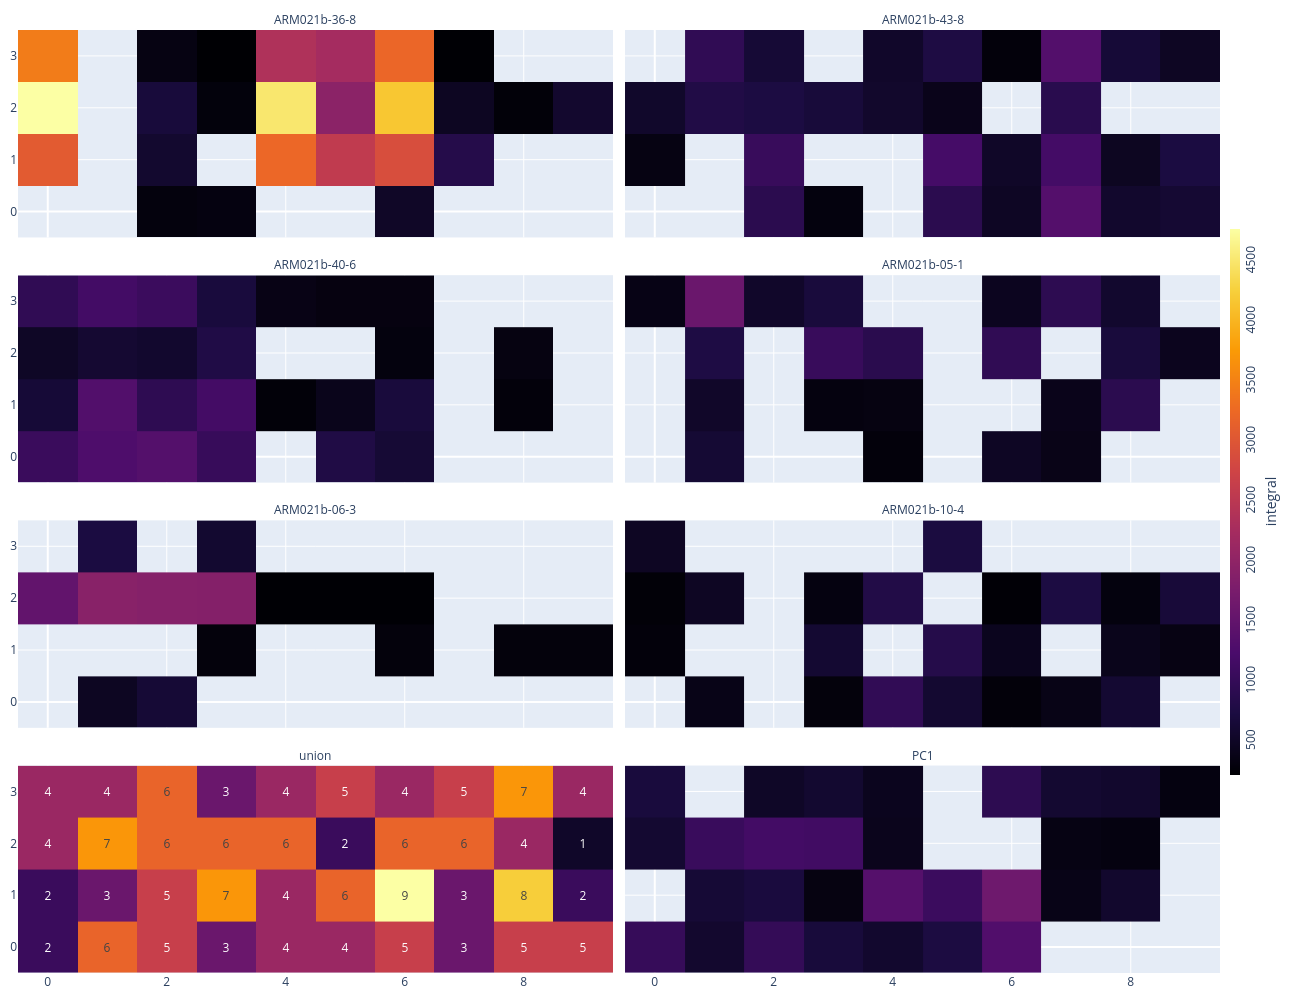

In [4]:
def plot_fingerprint(cellid):
    df = SC_DF.query(f"id == '{cellid}'")
    z = df.pivot(index='probe', columns='context_pair', values='value').values
    # z = z / np.max(z)
    z[z==0] = np.nan
    heatmap = go.Figure(go.Heatmap(z=z,coloraxis='coloraxis',connectgaps=False))
    try:
        thismax= np.nanmax(z)
    except:
        thismax = 0

    return heatmap, thismax

n_egs = 6 # this  number must be even
cell_egs = eg_site_df.loc[:n_egs-1,'id'].tolist()
titles = cell_egs+['union', 'PC1']
max_vals = list()
fig = make_subplots(int(n_egs/2+1) , 2,
                    shared_xaxes=True, shared_yaxes=True,
                    horizontal_spacing=0.01,vertical_spacing=0.04,
                    subplot_titles=titles)

# individual neuron examples
for cc, cell_eg in enumerate(cell_egs):
    hmap, maxval = plot_fingerprint(cell_eg)
    max_vals.append(maxval)
    row, col = int(np.floor(cc/2))+1, (cc%2)+1
    hmap = hmap['data']
    fig.add_traces(hmap, rows=[row]*len(hmap), cols=[col]*len(hmap))

# first principal component
PCA_arr = PCA_DF.query(f"site == '{site_eg}' and PC == 1"
                       ).pivot(index='probe', columns='context_pair', values='value').values
max_vals.append(PCA_arr.max())
PCA_arr[PCA_arr==0] = np.nan
pc1 =go.Heatmap(z=PCA_arr,coloraxis='coloraxis',connectgaps=False)
# pc = px.imshow(PCA_arr, origin='lower',)['data']
fig.add_trace(pc1, row=int(n_egs/2+1), col=2)

# union
union_arr = DF.query(
    f"analysis == 'SC' and mult_comp_corr == 'bf_ncp' and site == '{site_eg}'"
).pivot_table(
    index='probe', columns='context_pair', values='value', aggfunc=lambda x: np.sum(x>0)).values
toplot = union_arr / union_arr.max() * np.max(max_vals) # normalizatio of counts based on metric values
union = go.Figure(data=go.Heatmap(z=toplot, coloraxis='coloraxis',connectgaps=False))
union.update_traces(text=union_arr, texttemplate='%{text}') # add the count number to each cell, this wont be displayed by jupyternotebooks...
union = union['data']
fig.add_traces(union, rows=[int(n_egs/2+1)]*len(union), cols=[1]*len(union))


# some minor formating
fig.update_annotations(font_size=12)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  coloraxis=dict(colorscale='inferno',
                                     colorbar=dict(
                                         thickness=10, len=0.6,
                                         title_text='integral',
                                         title_side='right',
                                         tickangle=-90,
                                         xanchor='left', x=1)
                                     )
                  )
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)

# simple barplots

In [5]:
def union_cover(df):
    df = df.pivot_table(index='id', columns=['context_pair', 'probe'], values='value', aggfunc='first')
    arr =  df.dropna(axis=1).values > 0
    union = np.any(arr, axis=0)
    return union.sum()/union.size

def best_neuron(df):
    df = df.pivot_table(index='id', columns=['context_pair', 'probe'], values='value', aggfunc='first')
    arr =  df.dropna(axis=1).values > 0
    neu_cvr = arr.sum(axis=1) / arr.shape[1]
    return neu_cvr.max()



# all single neuron coverages
by_neuron = DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_cp'"
).groupby(['region', 'site', 'id']).agg(value=('value', lambda x: np.sum(x>0)/x.size))

# best neuron in site
by_best =  DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_cp'"
).groupby(['region', 'site']).apply(best_neuron)
by_best.name = 'value'

# Union of single neurons, note the more strict bonferroni
by_union =  DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_ncp'"
).groupby(['region', 'site']).apply(union_cover)
by_union.name = 'value'

# First PC coverage
by_PC1 = DF.query(
    "analysis == 'PCA' and PC == 1 and mult_comp_corr == 'bf_cp'"
).groupby(['region', 'site']).agg(value=('value', lambda x: np.sum(x>0)/x.size))


to_concat = {'SC':by_neuron, 'best_SC':by_best ,'union': by_union, 'PC1':by_PC1,}
toplot = list()
for name, df in to_concat.items():
    df = df.reset_index()
    df['quant'] = name
    toplot.append(df)
toplot = pd.concat(toplot)

In [6]:
# concatenate
to_concat = {'SC':by_neuron, 'best_SC':by_best ,'union': by_union, 'PC1':by_PC1}
toplot = list()
for name, df in to_concat.items():
    df = df.reset_index()
    df['quant'] = name
    toplot.append(df)
toplot = pd.concat(toplot)

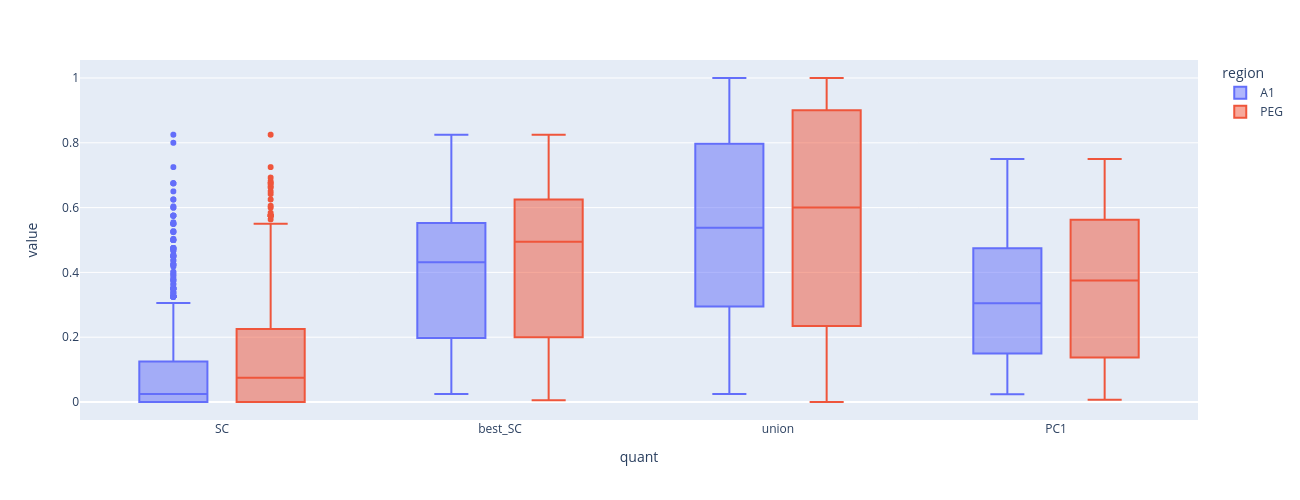

In [7]:
fig = px.box(data_frame=toplot, x='quant', y='value', color='region')
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

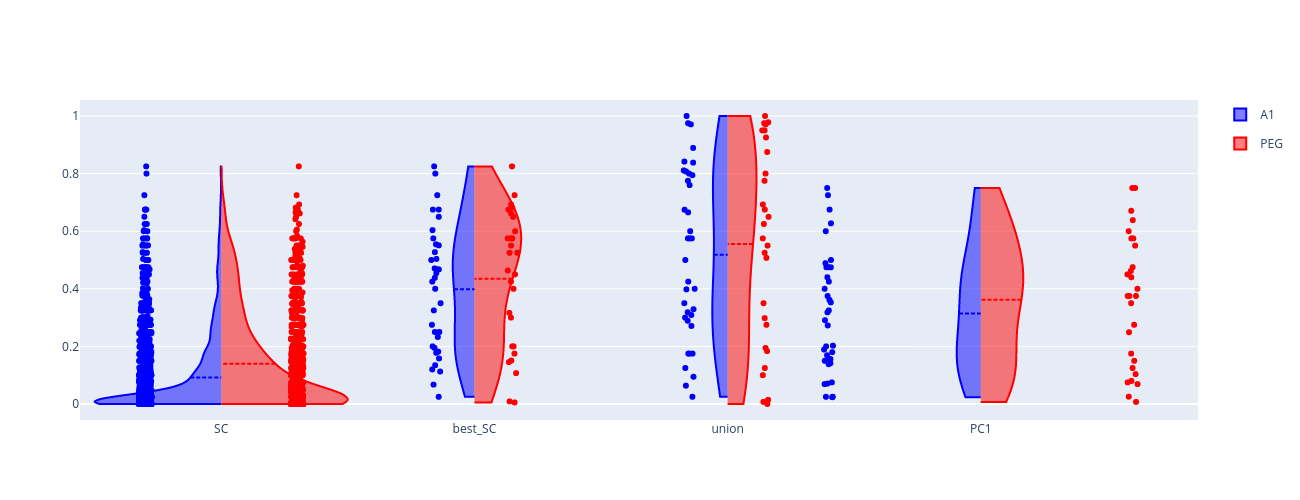

In [8]:

toplot = toplot.query("quant != 'best_PC'")

pointpos_A1 = [-0.6,-0.3,-0.3,-1.2]
pointpos_PEG = [0.6,0.3,0.3,1.2]
show_legend = [True,False,False,False]
fig = go.Figure()

for qq, quant in enumerate(toplot['quant'].unique()):
    fig.add_trace(go.Violin(x=toplot['quant'][(toplot['region'] == 'A1') &
                                        (toplot['quant'] == quant)],
                            y=toplot['value'][(toplot['region'] == 'A1') &
                                        (toplot['quant'] == quant)],
                            legendgroup='A1', scalegroup='A1', name='A1',
                            side='negative',
                            pointpos=pointpos_A1[qq], # where to position points
                            line_color='blue',
                            showlegend=show_legend[qq])
             )
    fig.add_trace(go.Violin(x=toplot['quant'][(toplot['region'] == 'PEG') &
                                        (toplot['quant'] == quant)],
                            y=toplot['value'][(toplot['region'] == 'PEG') &
                                        (toplot['quant'] == quant)],
                            legendgroup='PEG', scalegroup='PEG', name='PEG',
                            side='positive',
                            pointpos=pointpos_PEG[qq],
                            line_color='red',
                            showlegend=show_legend[qq])
             )

# update characteristics shared by all traces
fig.update_traces(meanline_visible=True,
                  points='all', # show all points
                  jitter=0.05,  # add some jitter on points for better visibility
                  scalemode='width',
                  spanmode='hard') #scale violin plot area with total count
fig.update_layout(
    title_text="",
    violingap=0, violingroupgap=0, violinmode='overlay')
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

## statistical quantifications

In [9]:
from scipy.stats import wilcoxon, mannwhitneyu
import itertools as itt

# compare between quantifications
stats_df = list()
for q0, q1 in itt.combinations(toplot.quant.unique(), 2):
    if 'SC' in [q0, q1]:
        x = toplot.query(f"quant == '{q0}'").value.values
        y = toplot.query(f"quant == '{q1}'").value.values
        assert np.all(~np.isnan(x))
        assert np.all(~np.isnan(y))
        out = mannwhitneyu(x,y)
        stat = 'mannwhitneyu'
    else:
        ddd = toplot.query(f"quant in {[q0, q1]}").pivot(index='site', columns='quant', values='value')
        x = ddd[q0].values
        y = ddd[q1].values
        assert np.all(~np.isnan(x))
        assert np.all(~np.isnan(y))
        out = wilcoxon(x,y)
        stat = 'wilcoxon'

    d = {'pair':f'{q0}_vs_{q1}', 'stat': stat, 'pvalue': out.pvalue}
    stats_df.append(d)

stats_df = pd.DataFrame(stats_df)
stats_df

,pair,stat,pvalue
0,SC_vs_best_SC,mannwhitneyu,3.863550e-25
1,SC_vs_union,mannwhitneyu,1.553574e-26
2,SC_vs_PC1,mannwhitneyu,3.175605e-19
3,best_SC_vs_union,wilcoxon,1.114828e-06
4,best_SC_vs_PC1,wilcoxon,1.353346e-05
5,union_vs_PC1,wilcoxon,4.493345e-09


In [10]:
# compare regions per quantification
stats_df = list()
for quant in toplot.quant.unique():
    if quant == 'SC':
        idx = 'id'
    else:
        idx = 'site'

    x = toplot.query(f"quant == '{quant}' and region == 'A1'").value.values
    y = toplot.query(f"quant == '{quant}' and region == 'PEG'").value.values

    assert np.all(~np.isnan(x))
    assert np.all(~np.isnan(y))
    out = mannwhitneyu(x,y)
    stat = 'mannwhitneyu'

    d = {'quant':quant, 'stat': stat, 'pvalue': out.pvalue}
    stats_df.append(d)

stats_df = pd.DataFrame(stats_df)
stats_df

,quant,stat,pvalue
0,SC,mannwhitneyu,7.754141e-08
1,best_SC,mannwhitneyu,2.386321e-01
2,union,mannwhitneyu,3.202441e-01
3,PC1,mannwhitneyu,2.181598e-01
